In [86]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Meiryo'

In [17]:
# CSVファイルを読み込み
df = pd.read_csv('./dataset_cur_train.csv',index_col = 0)
display(df.head(2))
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['red_diff'])
train_df.shape, test_df.shape

,red_diff,remain_ends,last_stone_is_red,red_posiotn,filepath
8,1.0,0,True,3.0,./dataset_o\ECC2023_ResultsBook_Women_A-Divisi...
0,2.0,8,True,0.0,./dataset_o\ECC2021_ResultsBook_Men_A-Division...


((11959, 5), (2990, 5))

In [213]:
len(train_df['red_diff'].unique() ),len(test_df['red_diff'].unique())

(11, 11)

In [219]:

from torch.utils.data import Dataset
from torchvision import transforms
import torchvision
from torchvision import datasets, models

from PIL import Image
import os

In [544]:
class ImgValueDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None):
        self.img_pathList  = df['filepath'].to_list()
        self.labels  = pd.get_dummies(df['red_diff']).values
        self.val_list  = df[['remain_ends','last_stone_is_red','red_posiotn']].astype(np.float16).values

        self.transform = transform
    
    def __len__(self):  
        return len( self.img_pathList )
    
    def __getitem__(self, index):
        # 画像をPILとして読み込む
        #print(index)
        src = self.img_pathList[index]
        #print(os.path.exists(src))
        image = Image.open(src)
        image = image.convert("RGB") 
        #numpy_img = np.asarray(image, np.float32) / 255.0
        #tensor_img = np.expand_dims(image, axis=0) # このままだとNWHCの形式
        
        label = self.labels[index]
        extend = self.val_list[index]                         
        if self.transform is not None:
            ##print('use transform')
            image = self.transform(image)
        extend_tensor = np.full((224,224),255)
        extend_tensor[1][0] = extend[0]
        extend_tensor[1][1] = extend[1]
        extend_tensor[1][2] = extend[2]
        extend_tensor = torch.Tensor(extend_tensor)
        extend_tensor = extend_tensor.unsqueeze(0)
        out = torch.cat([image, extend_tensor], dim=0)
        return out,label 

In [545]:
target_size = 224
transform = transforms.Compose([
    transforms.Pad(( 240 // 2, 0), fill=0, padding_mode='constant'),  # 左右に余白を追加
    transforms.Resize(target_size),
    transforms.CenterCrop(target_size),
    transforms.ToTensor()
])
myDataset = ImgValueDataset( train_df ,transform=transform)

In [546]:
inputs, classes = next(iter(myDataset))
inputs.shape

torch.Size([4, 224, 224])

In [547]:
image = inputs[:3]
image.shape

torch.Size([3, 224, 224])

In [548]:
values = inputs[3:]
print(values.shape , values)

torch.Size([1, 224, 224]) tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [  5.,   1.,  -7.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]]])


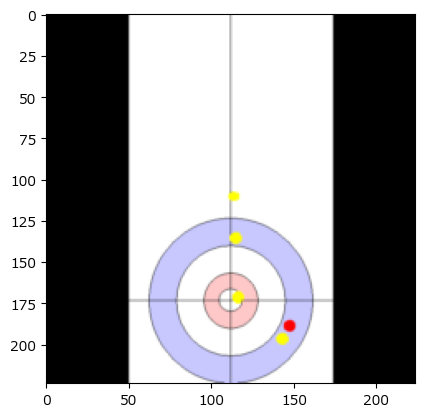

In [549]:
im = torchvision.transforms.functional.to_pil_image(image)
plt.imshow(im)

## データローダに仕立てる

In [581]:
import torch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms = True
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [582]:
target_size = 224
transform = transforms.Compose([
    transforms.Pad(( 240 // 2, 0), fill=0, padding_mode='constant'),  # 左右に余白を追加
    transforms.Resize(target_size),
    transforms.CenterCrop(target_size),
    transforms.ToTensor()
])
train_dataset = ImgValueDataset( train_df ,transform=transform)
test_dataset = ImgValueDataset( test_df ,transform=transform)

In [583]:

batch_size = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, drop_last=True)

In [584]:
a,b = next(iter(train_loader))
a.shape,b

(torch.Size([10, 4, 224, 224]),
 tensor([[False, False, False, False, False, False, False,  True, False, False,
          False],
         [False, False, False, False,  True, False, False, False, False, False,
          False],
         [False, False, False, False,  True, False, False, False, False, False,
          False],
         [False, False, False,  True, False, False, False, False, False, False,
          False],
         [False, False, False, False, False, False,  True, False, False, False,
          False],
         [False, False, False, False,  True, False, False, False, False, False,
          False],
         [False, False, False,  True, False, False, False, False, False, False,
          False],
         [False, False, False, False,  True, False, False, False, False, False,
          False],
         [False, False, False, False, False, False,  True, False, False, False,
          False],
         [False, False, False,  True, False, False, False, False, False, False,
      

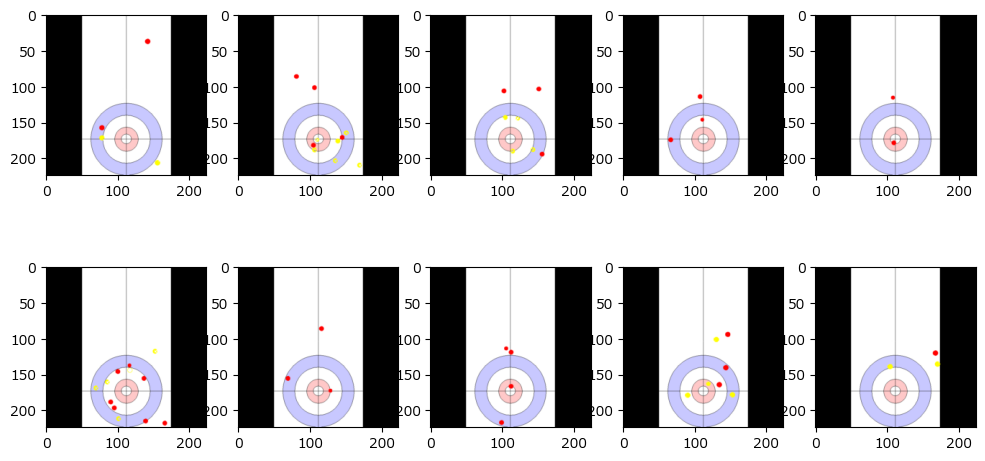

In [554]:
## イメージ分離
images = a[:,:3]
k ,_,_,_ = images.shape
imlist = []
for i in range(k):
    data = images[i]
    im = torchvision.transforms.functional.to_pil_image(data)
    imlist.append(im)
n = len(imlist)
fig , axs = plt.subplots(2, n//2,figsize=(12,6))
axs = axs.flatten()
for i in range(n):
    axs[i].imshow(imlist[i])

In [555]:
## 値分離
values = a[:,3:]
k ,_,_,_ = images.shape
imlist = []
for i in range(k):
    data = values[i]
    print(data[0][1][0:3])

tensor([ 1.,  1., -1.])
tensor([ 1.,  1., -1.])
tensor([ 7.,  1., -2.])
tensor([ 6.,  0., -1.])
tensor([ 2.,  0., -1.])
tensor([1., 0., 3.])
tensor([3., 0., 0.])
tensor([8., 0., 0.])
tensor([ 0.,  1., -2.])
tensor([7., 0., 2.])


Netを組む

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
# CNNモデルの定義
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        viewCnt = (32 * 56 * 56)
        
        self.fc1 = nn.Linear(viewCnt+3, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        images = x[:,:3]
        values = x[:,3:]
        images = self.pool(F.relu(self.conv1(images)))
        images = self.pool(F.relu(self.conv2(images)))
        images = images.view(-1, 32 * 56 * 56)
        ## -- 結合します
        params = values[:,0,1,0:3]
        packedData = torch.cat([images,params],1)
        #print(images.shape,values.shape,packedData.shape)
        packedData = F.relu(self.fc1(packedData))
        packedData = self.fc2(packedData)
        packedData
        return packedData

In [4]:
num_classes = len(train_df['red_diff'].unique() )
cnn_model = SimpleCNN(num_classes=num_classes)

NameError: name 'train_df' is not defined

In [627]:
cnn_model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100355, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=11, bias=True)
)

In [628]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, drop_last=True)

imput , label = next(iter(train_loader))
imput.shape
num_classes = len(train_df['red_diff'].unique() )
cnn_model = SimpleCNN(num_classes=num_classes)
cnn_model(imput)

tensor([[-0.0103,  0.0155, -0.0108,  0.0402,  0.0179,  0.0245,  0.0296, -0.0098,
          0.0804,  0.0818,  0.0398],
        [-0.0053,  0.0050, -0.0102,  0.0438,  0.0216,  0.0311,  0.0274, -0.0100,
          0.0817,  0.0802,  0.0462],
        [-0.0017,  0.0025, -0.0081,  0.0454,  0.0235,  0.0315,  0.0248, -0.0088,
          0.0838,  0.0819,  0.0520],
        [-0.0080,  0.0159, -0.0096,  0.0410,  0.0174,  0.0254,  0.0300, -0.0100,
          0.0810,  0.0795,  0.0410],
        [-0.0082,  0.0124, -0.0094,  0.0425,  0.0187,  0.0249,  0.0309, -0.0054,
          0.0811,  0.0825,  0.0430],
        [-0.0053,  0.0014, -0.0088,  0.0443,  0.0230,  0.0306,  0.0247, -0.0107,
          0.0842,  0.0812,  0.0481],
        [-0.0043,  0.0022, -0.0085,  0.0448,  0.0238,  0.0318,  0.0226, -0.0097,
          0.0833,  0.0812,  0.0466],
        [-0.0078,  0.0142, -0.0099,  0.0402,  0.0192,  0.0259,  0.0247, -0.0112,
          0.0780,  0.0812,  0.0382],
        [-0.0071,  0.0089, -0.0095,  0.0416,  0.0211,  0

In [629]:
values = a[:,3:]
j = values[:,0,1,0:3]
dmyimg = np.full((10,100352),255)
qimage = torch.Tensor(dmyimg)
qimage.shape
torch.cat([qimage,j],1)

tensor([[255., 255., 255.,  ...,   1.,   1.,  -1.],
        [255., 255., 255.,  ...,   1.,   1.,  -1.],
        [255., 255., 255.,  ...,   7.,   1.,  -2.],
        ...,
        [255., 255., 255.,  ...,   8.,   0.,   0.],
        [255., 255., 255.,  ...,   0.,   1.,  -2.],
        [255., 255., 255.,  ...,   7.,   0.,   2.]])

In [630]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [631]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, drop_last=True)
# 学習
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_df['red_diff'].unique() )
criterion = nn.CrossEntropyLoss()
model_gpu = SimpleCNN(num_classes=num_classes).to(device)
optimizer_gpu =  optim.Adam(model_gpu.parameters(), lr=0.001)

train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #testのlossを保持するlist
test_acc_value=[]        #testのaccuracyを保持するlist 

num_epochs = 30
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels_float = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model_gpu(images)
        loss = criterion(outputs, labels_float)
        loss.backward()
        optimizer_gpu.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/30], Loss: 2.049813985824585
Epoch [2/30], Loss: 1.9412364959716797
Epoch [3/30], Loss: 2.23701810836792
Epoch [4/30], Loss: 1.8757498264312744
Epoch [5/30], Loss: 1.9354826211929321
Epoch [6/30], Loss: 1.9489898681640625
Epoch [7/30], Loss: 1.8421339988708496
Epoch [8/30], Loss: 1.8763848543167114
Epoch [9/30], Loss: 1.7491627931594849
Epoch [10/30], Loss: 2.2668769359588623
Epoch [11/30], Loss: 2.284719705581665
Epoch [12/30], Loss: 1.9038636684417725
Epoch [13/30], Loss: 2.1178297996520996
Epoch [14/30], Loss: 1.8216854333877563
Epoch [15/30], Loss: 2.1496520042419434
Epoch [16/30], Loss: 2.1029052734375
Epoch [17/30], Loss: 2.052807569503784
Epoch [18/30], Loss: 1.9326159954071045
Epoch [19/30], Loss: 1.806288242340088
Epoch [20/30], Loss: 2.06113338470459
Epoch [21/30], Loss: 1.8549997806549072
Epoch [22/30], Loss: 1.8652833700180054
Epoch [23/30], Loss: 1.8619627952575684
Epoch [24/30], Loss: 1.7914745807647705
Epoch [25/30], Loss: 1.8464398384094238
Epoch [26/30], Loss:

In [632]:
Epoch [1/5], Loss: 2.3228600025177
Epoch [2/5], Loss: 1.8527653217315674
Epoch [3/5], Loss: 2.0662903785705566
Epoch [4/5], Loss: 2.3889870643615723
Epoch [5/5], Loss: 1.7179456949234009

SyntaxError: only single target (not tuple) can be annotated (3721656434.py, line 1)

In [533]:
one_hot = F.one_hot(labels_int), num_classes=num_classes)

SyntaxError: cannot assign to function call (1370988544.py, line 1)

In [534]:
one_hot = F.one_hot(labels_int), num_classes=num_classes)

SyntaxError: cannot assign to function call (1370988544.py, line 1)

In [539]:
F.one_hot(labels_int,num_classes=num_classes)

RuntimeError: Class values must be non-negative.

In [562]:
labels_int

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [543]:
pd.get_dummies(df['red_diff']).values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])